In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = 0, L = 10, T = 10):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*(w+us)**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 2000

    xs = np.linspace(-5, L, M)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.05):
        for j in np.arange(0, 20, 0.01):
            psiExato[r][int(j*100)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psi, psiExato):
    A = np.zeros((200,200))
    B = np.zeros((200,200))
    C = np.zeros((200,200))
    D = np.zeros((200,200))
    A = multMatrizes(M = 200, us = x[0])
    B = multMatrizes(M = 200, us = x[1])
    C = multMatrizes(M = 200, us = x[0])
    D = multMatrizes(M = 200, us = x[1])
    
    Y = np.matmul(A,psi[0:200, y])
    Z = np.matmul(B, Y)
    W = np.matmul(C, Z)
    X = np.matmul(D, W)
    
    return ((np.linalg.norm(np.array(psiExato[0:200, y])-np.array(psi[0:200, y])))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+1])-np.array(Y)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+2])-np.array(Z)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+3])-np.array(W)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+4])-np.array(X)))**2)

In [6]:
import random

psi = np.zeros((200,2000))
psi_f = np.zeros((200,2000))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 200, O = -5, L = 5, T = 20)
psiExato = ExactSolution(M = 200)

In [7]:
xs = np.linspace(-5,5,200)

[-2.253138167996742, -1.4605197375351278, 1.726570109213049, 0.617518394955229]
Iteração: 1
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.6467094149894907
       x: [-2.237e+00 -2.188e+00  1.727e+00  6.175e-01]
     nit: 7
     jac: [-2.682e-06  1.848e-06  0.000e+00  0.000e+00]
    nfev: 85
    njev: 17
---------------
[-2.236850504690271, 1.7166310351348644, -4.699740770900607, -3.7775259995497636]
Iteração: 2
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.7070044125519925
       x: [-4.066e+00 -4.090e+00 -4.700e+00 -3.778e+00]
     nit: 13
     jac: [ 2.205e-06  1.818e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-4.066452993030857, 0.7439205054333229, -1.5821480983286396, -2.144501642705219]
Iteração: 3
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.7914379687427155
       x: [-4.072e+00 -2.194e+00 -1.582e+00 -2.145e+00]
     nit: 14
     

Iteração: 24
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 10.135489385463217
       x: [-2.205e+00 -4.091e+00  4.156e+00  1.821e+00]
     nit: 10
     jac: [ 2.027e-06  8.345e-06  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
---------------
[-2.205348827098493, -4.032492280659241, 0.7951467868694486, 3.08389999087629]
Iteração: 25
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 10.88622975123114
       x: [-2.316e+00 -4.365e+00  7.951e-01  3.084e+00]
     nit: 15
     jac: [-1.311e-06 -7.153e-06  0.000e+00  0.000e+00]
    nfev: 125
    njev: 25
---------------
[-2.3157781424982735, 2.1547027832127155, 0.11165312842512876, 1.2002621480898457]
Iteração: 26
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 28.881592871481395
       x: [-1.964e+00 -2.192e+00  1.117e-01  1.200e+00]
     nit: 12
     jac: [-2.384e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31


Iteração: 47
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 30.231611670976502
       x: [-2.196e+00 -2.187e+00 -1.069e+00 -4.170e+00]
     nit: 12
     jac: [ 4.768e-06 -4.768e-07  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
---------------
[-2.1956171052551348, -1.3601838587652324, 4.876155858809907, -0.43606909546664596]
Iteração: 48
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 31.384126321906933
       x: [-2.195e+00 -2.187e+00  4.876e+00 -4.361e-01]
     nit: 6
     jac: [ 6.199e-06 -6.914e-06  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16
---------------
[-2.1950422111985923, -3.227438372571625, -3.7707337410706354, -1.2985314478337884]
Iteração: 49
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 32.55935509189506
       x: [-2.195e+00 -4.097e+00 -3.771e+00 -1.299e+00]
     nit: 11
     jac: [-9.537e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev:

Iteração: 70
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 62.30068795260705
       x: [-4.101e+00 -4.099e+00  2.243e+00  3.257e+00]
     nit: 15
     jac: [ 4.768e-06 -4.768e-06  0.000e+00  0.000e+00]
    nfev: 135
    njev: 27
---------------
[-4.1011823839454316, -2.8718902171152028, 1.3450103178917683, -0.02968097743411846]
Iteração: 71
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 63.94663053451979
       x: [-4.102e+00 -2.184e+00  1.345e+00 -2.968e-02]
     nit: 12
     jac: [ 6.676e-06 -5.245e-06  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31
---------------
[-4.102003847492896, 4.9070089922077536, -3.089379132161445, -4.249760366121943]
Iteração: 72
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 65.61218697526365
       x: [-4.103e+00 -4.099e+00 -3.089e+00 -4.250e+00]
     nit: 18
     jac: [-5.722e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 3

Iteração: 93
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 104.69663597978571
       x: [-2.160e+00 -2.190e+00  2.201e+00 -2.675e+00]
     nit: 11
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-2.160254807978212, 4.238336342089884, 0.11920232614104354, -4.919212098228863]
Iteração: 94
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 106.72944295674522
       x: [-4.125e+00 -2.191e+00  1.192e-01 -4.919e+00]
     nit: 16
     jac: [ 6.676e-06 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 215
    njev: 43
---------------
[-4.124757171502871, 0.5052606489305731, 3.6039243307306936, -4.278171893694834]
Iteração: 95
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 108.77530660299158
       x: [-4.126e+00 -2.191e+00  3.604e+00 -4.278e+00]
     nit: 9
     jac: [ 2.861e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23


Iteração: 116
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 143.3950613902162
       x: [-1.235e+00 -1.068e+00 -1.238e+00  8.494e-01]
     nit: 11
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31
---------------
[-1.235262534332014, 3.62485853725652, 1.3563325712005483, -1.1370596126186228]
Iteração: 117
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 144.82044298944157
       x: [-5.096e+00 -9.915e-01  1.356e+00 -1.137e+00]
     nit: 13
     jac: [-1.907e-06 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev: 40
---------------
[-5.095780484338497, 2.705027826609671, -2.290810153291143, 4.646144097953583]
Iteração: 118
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 156.98378688756938
       x: [-5.181e+00 -9.987e-01 -2.291e+00  4.646e+00]
     nit: 12
     jac: [ 1.907e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29


Iteração: 139
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 170.4139042662418
       x: [-1.600e+00 -1.628e+00  5.420e-01  3.420e+00]
     nit: 12
     jac: [-5.722e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 135
    njev: 27
---------------
[-1.5997770784269802, 1.8917465265721312, -0.4055429987698389, 0.3053744713365134]
Iteração: 140
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 170.23343987566045
       x: [-1.623e+00 -1.651e+00 -4.055e-01  3.054e-01]
     nit: 13
     jac: [ 9.537e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 120
    njev: 24
---------------
[-1.6231186705312017, -0.8606594759003823, 2.788566721850402, 3.9848089382094862]
Iteração: 141
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 170.01183874039438
       x: [-1.646e+00 -1.674e+00  2.789e+00  3.985e+00]
     nit: 11
     jac: [ 9.537e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 125
    nje

Iteração: 162
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 160.62478617072918
       x: [-4.296e+00 -2.014e+00  1.999e-01  2.354e+00]
     nit: 16
     jac: [ 1.907e-06  1.907e-06  0.000e+00  0.000e+00]
    nfev: 265
    njev: 53
---------------
[-4.296198594441305, -3.3298473597194733, 0.00904929166195334, 4.694999511064125]
Iteração: 163
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 160.11162430926097
       x: [-4.286e+00 -4.258e+00  9.049e-03  4.695e+00]
     nit: 12
     jac: [-1.907e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 170
    njev: 34
---------------
[-4.285646797358762, -4.153288859786474, -4.474638912985286, -3.780616093591406]
Iteração: 164
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 159.6024434962237
       x: [-4.275e+00 -4.248e+00 -4.475e+00 -3.781e+00]
     nit: 5
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 80
    njev: 1

Iteração: 185
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 151.0664177892171
       x: [-2.153e+00 -2.178e+00 -4.278e+00 -6.014e-01]
     nit: 13
     jac: [-3.815e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36
---------------
[-2.1525287288814936, -1.0833987303453907, 1.631041198673831, -2.5123082251502526]
Iteração: 186
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 150.8054263769742
       x: [-2.156e+00 -2.183e+00  1.631e+00 -2.512e+00]
     nit: 10
     jac: [ 1.907e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 135
    njev: 27
---------------
[-2.1564314383874144, 2.3080548819045603, 1.9461368207812182, -2.9282876300368144]
Iteração: 187
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 150.56037694897827
       x: [-4.122e+00 -2.186e+00  1.946e+00 -2.928e+00]
     nit: 12
     jac: [-3.815e-06  9.537e-06  0.000e+00  0.000e+00]
    nfev: 210
    nje

Iteração: 208
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 139.43301074522313
       x: [-2.666e+00 -2.142e+00 -5.088e-01  4.014e+00]
     nit: 12
     jac: [-5.722e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38
---------------
[-2.6659643068501677, -4.568703946116827, 4.242548711423542, 4.869550966587825]
Iteração: 209
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 149.49245559192275
       x: [-2.306e+00 -4.070e+00  4.243e+00  4.870e+00]
     nit: 9
     jac: [ 1.907e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 130
    njev: 26
---------------
[-2.3063773971132746, -2.2177947080580616, -1.4759369995101679, -3.717577166570986]
Iteração: 210
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 149.64584813937978
       x: [-2.241e+00 -2.233e+00 -1.476e+00 -3.718e+00]
     nit: 4
     jac: [-5.722e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 65
    njev: 

Iteração: 231
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 145.41002645934537
       x: [-4.392e+00 -3.142e+00  3.786e+00  3.303e-01]
     nit: 18
     jac: [ 3.815e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 290
    njev: 58
---------------
[-4.392163314487607, 1.4028933715882754, -0.3490377535432092, -4.217362379560274]
Iteração: 232
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 145.91595020499955
       x: [-3.875e+00 -2.345e+00 -3.490e-01 -4.217e+00]
     nit: 17
     jac: [ 1.907e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 270
    njev: 54
---------------
[-3.8750456443861325, -4.9765007539354436, -1.8820837720821917, 0.807008034438522]
Iteração: 233
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 146.2995208418024
       x: [-3.822e+00 -4.093e+00 -1.882e+00  8.070e-01]
     nit: 13
     jac: [ 5.722e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 195
    nje

Iteração: 254
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 171.5638406735073
       x: [-4.011e+00 -2.284e+00 -1.113e+00  3.165e+00]
     nit: 11
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 185
    njev: 37
---------------
[-4.011485420568895, 2.7869644710607044, 2.8199283797160177, 3.8115044587713474]
Iteração: 255
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 172.34206914310738
       x: [-2.275e+00 -2.290e+00  2.820e+00  3.812e+00]
     nit: 7
     jac: [ 9.537e-06  5.722e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev: 30
---------------
[-2.274578767529693, 4.093849325414343, 3.1844321967350293, 3.653892742060936]
Iteração: 256
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 173.12958026333607
       x: [-4.005e+00 -2.296e+00  3.184e+00  3.654e+00]
     nit: 14
     jac: [ 5.722e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 245
    njev: 49


Iteração: 277
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 161.5180130389072
       x: [-6.765e+00 -3.142e+00  4.048e+00 -6.103e-01]
     nit: 24
     jac: [-7.629e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 245
    njev: 49
---------------
[-6.765400010095012, 4.040818558094472, -1.8122603864132891, 2.003090698211299]
Iteração: 278
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 160.12179552599633
       x: [-5.574e+00 -2.432e+00 -1.812e+00  2.003e+00]
     nit: 14
     jac: [ 7.629e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 200
    njev: 40
---------------
[-5.574047374887755, -4.969049899255518, -2.266888747302811, 0.23726509324046763]
Iteração: 279
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 158.909937887538
       x: [-4.813e+00 -4.258e+00 -2.267e+00  2.373e-01]
     nit: 7
     jac: [ 3.815e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 110
    njev: 22


Iteração: 300
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 135.91467646536057
       x: [-1.894e+00 -1.831e+00  2.916e+00 -4.363e+00]
     nit: 5
     jac: [-9.537e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-1.8943187654557283, -4.5503279904852025, 1.749625946441248, -4.890321138169459]
Iteração: 301
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 134.97567603941314
       x: [-1.893e+00 -4.454e+00  1.750e+00 -4.890e+00]
     nit: 5
     jac: [ 5.722e-06  1.907e-06  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-1.8930344073812706, 2.755819030305446, -0.291794528222578, -2.764502200670046]
Iteração: 302
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 134.05619343832853
       x: [-1.893e+00 -1.826e+00 -2.918e-01 -2.765e+00]
     nit: 11
     jac: [-7.629e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36

Iteração: 323
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 120.2813278594687
       x: [-4.397e+00 -1.786e+00  2.036e+00 -2.700e+00]
     nit: 7
     jac: [ 2.861e-06 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
---------------
[-4.397305799929712, 4.452852038691519, -1.190399879154218, 3.7581703276345806]
Iteração: 324
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 119.93215474145362
       x: [-4.397e+00 -1.784e+00 -1.190e+00  3.758e+00]
     nit: 14
     jac: [-1.907e-06 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 210
    njev: 42
---------------
[-4.3973952716369, -2.7240868417563204, 0.9332813731426661, 4.927837685032884]
Iteração: 325
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 119.61418604020545
       x: [-4.398e+00 -1.782e+00  9.333e-01  4.928e+00]
     nit: 11
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 180
    njev: 36
-

Iteração: 346
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 120.54503143071165
       x: [-4.401e+00 -1.717e+00  7.964e-01  6.294e-01]
     nit: 10
     jac: [ 0.000e+00 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 155
    njev: 31
---------------
[-4.401056354442751, 4.672935885899728, -4.710033936534549, 0.06045569517578375]
Iteração: 347
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 120.9586782188347
       x: [-4.401e+00 -1.712e+00 -4.710e+00  6.046e-02]
     nit: 10
     jac: [-4.768e-06  9.537e-06  0.000e+00  0.000e+00]
    nfev: 175
    njev: 35
---------------
[-4.401124638186617, -1.9654718521256012, 1.722054560526658, 4.610855512865697]
Iteração: 348
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 121.40536864525701
       x: [-4.402e+00 -1.708e+00  1.722e+00  4.611e+00]
     nit: 8
     jac: [ 2.861e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 115
    njev: 23

Iteração: 369
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 137.80501025276288
       x: [-1.873e+00 -1.555e+00  4.253e+00  4.275e+00]
     nit: 10
     jac: [ 1.907e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-1.872804609359392, -2.810871221959271, 2.9049539028849996, -3.127732618033887]
Iteração: 370
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 138.8799103771496
       x: [-1.873e+00 -1.544e+00  2.905e+00 -3.128e+00]
     nit: 11
     jac: [ 0.000e+00  5.722e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-1.8727579513257846, -1.8712315500461676, 3.443353374013908, -1.9101112734369674]
Iteração: 371
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 139.9770279388006
       x: [-1.872e+00 -1.534e+00  3.443e+00 -1.910e+00]
     nit: 11
     jac: [ 1.907e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 150
    njev:

Iteração: 392
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.8834799270314
       x: [-1.981e+00 -1.273e+00  2.751e+00 -4.329e+00]
     nit: 10
     jac: [ 1.907e-06  9.537e-06  0.000e+00  0.000e+00]
    nfev: 160
    njev: 32
---------------
[-1.981295943633092, -2.6992581150330275, -4.75452920847499, -2.4911255867890567]
Iteração: 393
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.28294555183226
       x: [-1.999e+00 -1.270e+00 -4.755e+00 -2.491e+00]
     nit: 15
     jac: [ 3.815e-06  3.815e-06  0.000e+00  0.000e+00]
    nfev: 265
    njev: 53
---------------
[-1.9992639547776818, -4.983458337280544, -1.2200141538078721, -0.7532498464493242]
Iteração: 394
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.6860445252504
       x: [-2.022e+00 -5.014e+00 -1.220e+00 -7.532e-01]
     nit: 10
     jac: [ 1.907e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 185
    nje

Iteração: 415
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 177.2704244900085
       x: [-3.142e+00 -3.142e+00  3.760e+00  8.097e-02]
     nit: 9
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 170
    njev: 34
---------------
[-3.1416027239211606, 2.5587478493670837, -2.315253599373941, -2.412007714015363]
Iteração: 416
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.12715036148592
       x: [-3.142e+00 -3.141e+00 -2.315e+00 -2.412e+00]
     nit: 6
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 110
    njev: 22
---------------
[-3.141577665802185, -4.611381440760436, -2.4892539979515482, -4.189316360983061]
Iteração: 417
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.9544218241542
       x: [-3.142e+00 -3.142e+00 -2.489e+00 -4.189e+00]
     nit: 3
     jac: [ 5.722e-06 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16


Iteração: 438
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 179.8710642078017
       x: [-3.142e+00 -3.142e+00  3.574e+00 -2.655e+00]
     nit: 3
     jac: [ 1.907e-06  0.000e+00  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.141589327722676, -1.4330924804987468, 2.655053657485448, 4.672129128565272]
Iteração: 439
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 179.187092162834
       x: [-3.142e+00 -3.142e+00  2.655e+00  4.672e+00]
     nit: 1
     jac: [-3.815e-06 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415961560677044, -4.1838368046688545, -2.1775341011500626, 3.837823823807181]
Iteração: 440
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 178.51972641590763
       x: [-3.142e+00 -3.142e+00 -2.178e+00  3.838e+00]
     nit: 3
     jac: [-1.907e-06  9.537e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
-----

Iteração: 461
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 155.1013131381686
       x: [-3.142e+00 -3.142e+00  4.805e-01 -3.963e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415927316594345, -4.449786954953946, 0.8640322637602207, -1.1432800317816572]
Iteração: 462
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 153.15815533572012
       x: [-3.142e+00 -3.142e+00  8.640e-01 -1.143e+00]
     nit: 6
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415927316594345, 4.938402927484507, -2.9310412380026674, 2.0184473381552523]
Iteração: 463
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 151.18688807456385
       x: [-3.142e+00 -3.142e+00 -2.931e+00  2.018e+00]
     nit: 1
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---

Iteração: 484
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 122.05331541376846
       x: [-3.142e+00 -3.142e+00  3.248e+00  7.083e-01]
     nit: 1
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 20
    njev: 4
---------------
[-3.1415927316594345, 3.3930373223550845, 0.5130486984117146, 0.8824783631103363]
Iteração: 485
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 119.73560056459725
       x: [-3.142e+00 -3.142e+00  5.130e-01  8.825e-01]
     nit: 3
     jac: [-9.537e-07  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.141593501966489, -1.8852234418659641, -2.9099722305307987, -1.9287482332455852]
Iteração: 486
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 114.85655870514479
       x: [-3.142e+00 -3.142e+00 -2.910e+00 -1.929e+00]
     nit: 11
     jac: [ 0.000e+00  4.768e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12

Iteração: 507
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 93.74917879482841
       x: [-3.142e+00 -3.142e+00 -1.353e+00  5.488e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, 2.019537071397207, -3.9977172671701124, -1.937353306288757]
Iteração: 508
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 93.34338881649361
       x: [-3.142e+00 -3.142e+00 -3.998e+00 -1.937e+00]
     nit: 3
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, 1.2617761367738858, 2.4937836061412098, 0.7318918186828558]
Iteração: 509
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 93.01580774219617
       x: [-3.142e+00 -3.142e+00  2.494e+00  7.319e-01]
     nit: 5
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14
-----

Iteração: 530
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 101.4493636087195
       x: [-3.142e+00 -1.768e-01  2.225e+00  1.440e-01]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, 4.108716812007039, 3.204830217901284, 0.5714003898556266]
Iteração: 531
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 102.3981211588369
       x: [-3.142e+00 -8.144e-02  3.205e+00  5.714e-01]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -1.4095024621228278, -4.54964836035895, 2.1313946440086253]
Iteração: 532
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 103.38454386332552
       x: [-3.142e+00  1.074e-02 -4.550e+00  2.131e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
------

Iteração: 553
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 129.66341521991387
       x: [-3.142e+00  1.522e+00  2.421e+00  4.862e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.1415926026775196, 2.4802294840924226, 4.9201430085623254, 4.445209309897457]
Iteração: 554
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 131.0249875494665
       x: [-3.142e+00  1.582e+00  4.920e+00  4.445e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -4.372565332517059, -2.937781576151454, 1.7644083994720994]
Iteração: 555
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 132.38278928917927
       x: [-3.142e+00 -7.925e+00 -2.938e+00  1.764e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
----

Iteração: 576
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 157.47412847452517
       x: [-3.142e+00  2.774e+00  7.318e-02 -1.221e+00]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, 3.8560163391287148, 2.4292169921100273, -2.7572495177532295]
Iteração: 577
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 158.4111634488377
       x: [-3.142e+00  2.824e+00  2.429e+00 -2.757e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -0.9994418423198592, -3.483485193352619, 0.027628914587688236]
Iteração: 578
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 159.3188813458298
       x: [-3.142e+00  2.874e+00 -3.483e+00  2.763e-02]
     nit: 4
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10


Iteração: 599
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 171.47648787221246
       x: [-3.142e+00  3.888e+00  1.961e+00  3.833e+00]
     nit: 2
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, 3.7722281114472427, -2.3759852102649734, -4.117013228710792]
Iteração: 600
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 171.7497632911726
       x: [-3.142e+00  3.935e+00 -2.376e+00 -4.117e+00]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -4.145594242517282, 0.7978154796867365, 0.4974365424806928]
Iteração: 601
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 203.31892193003534
       x: [-3.142e+00 -1.122e+02  7.978e-01  4.974e-01]
     nit: 7
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 245
    njev: 49
-

Iteração: 622
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 173.56853439921125
       x: [-3.142e+00  5.011e+00  1.556e+00  2.787e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 3.4722375089291972, 0.4074841801760707, 0.6241715598531927]
Iteração: 623
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 173.55650157473212
       x: [-3.142e+00  5.063e+00  4.075e-01  6.242e-01]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -0.902297508877357, -1.0586914003486072, 2.1715690287922467]
Iteração: 624
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 173.54474821080467
       x: [-3.142e+00  5.114e+00 -1.059e+00  2.172e+00]
     nit: 2
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14


Iteração: 645
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 174.91622866351037
       x: [-3.142e+00  6.315e+00 -3.564e+00  1.213e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -0.7268211095400279, 0.6783243624088309, 0.733152006237189]
Iteração: 646
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 175.11586365952053
       x: [-3.142e+00  6.380e+00  6.783e-01  7.332e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 3.8165119244784815, -2.8872982292348546, -1.7725985107800488]
Iteração: 647
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 175.33111903715448
       x: [-3.142e+00  6.445e+00 -2.887e+00 -1.773e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9

Iteração: 668
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 183.39258962300096
       x: [-3.142e+00  8.074e+00  4.771e+00 -1.314e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -1.770452365509585, 4.7008623741703985, -1.9241739199823495]
Iteração: 669
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 183.92040213892895
       x: [-3.142e+00  8.168e+00  4.701e+00 -1.924e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 105
    njev: 21
---------------
[-3.1415926026775196, 3.0159745643883458, 4.937811563110323, -3.547769881776156]
Iteração: 670
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 184.4573403493485
       x: [-3.142e+00  8.264e+00  4.938e+00 -3.548e+00]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
--

Iteração: 691
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 196.60314676057854
       x: [-3.142e+00  1.086e+01  3.512e+00 -1.240e+00]
     nit: 1
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14
---------------
[-3.1415926026775196, -2.213682587068101, -4.163776834611426, 4.658846854302688]
Iteração: 692
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.16588189518697
       x: [-3.142e+00  1.102e+01 -4.164e+00  4.659e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -0.7445365476459678, -4.193452826517018, 1.9858120205782326]
Iteração: 693
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.72203805109655
       x: [-3.142e+00  1.119e+01 -4.193e+00  1.986e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 70
    njev: 14


Iteração: 714
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 206.5526634837248
       x: [-3.142e+00  1.761e+01  4.976e+00  1.055e+00]
     nit: 6
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 190
    njev: 38
---------------
[-3.1415926026775196, 1.3280658641534089, -2.8552825676904767, 0.6190982309038473]
Iteração: 715
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 206.8099063371371
       x: [-3.142e+00  1.804e+01 -2.855e+00  6.191e-01]
     nit: 3
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-3.1415926026775196, 1.9761448980717198, -0.35056115097149476, 2.6057746941431725]
Iteração: 716
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 207.05469490288465
       x: [-3.142e+00  1.848e+01 -3.506e-01  2.606e+00]
     nit: 6
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 120
    njev: 

Iteração: 737
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.50528213421813
       x: [-3.142e+00  4.730e+01 -9.678e-01 -3.760e+00]
     nit: 6
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 140
    njev: 28
---------------
[-3.1415926026775196, -1.0070374730724687, 1.1297394761487496, 1.6942134035357084]
Iteração: 738
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.52418781086618
       x: [-3.142e+00  4.945e+01  1.130e+00  1.694e+00]
     nit: 8
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 345
    njev: 69
---------------
[-3.1415926026775196, 4.853733195257936, 3.7681203816608555, 0.042294685150255695]
Iteração: 739
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.53849655920945
       x: [-3.142e+00  5.177e+01  3.768e+00  4.229e-02]
     nit: 9
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 410
    njev

Iteração: 760
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.0977927881782
       x: [-3.142e+00  3.337e+02 -1.018e+00  4.176e+00]
     nit: 5
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 235
    njev: 47
---------------
[-3.1415926026775196, 3.644350144207122, -0.0318086298903264, -2.5167386090569166]
Iteração: 761
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 210.23267714542388
       x: [-3.142e+00  1.152e+01 -3.181e-02 -2.517e+00]
     nit: 6
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 130
    njev: 26
---------------
[-3.1415926026775196, 3.3256710331348724, -0.30853097611286184, -1.0925345897111627]
Iteração: 762
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.95638083808697
       x: [-3.142e+00  1.121e+01 -3.085e-01 -1.093e+00]
     nit: 7
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 135
    nje

Iteração: 783
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 242.25350676639624
       x: [-3.142e+00 -3.142e+00  1.655e+00 -4.699e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, 3.7504761061979703, 3.7473690446351835, 3.980844712270855]
Iteração: 784
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 205.20316816020866
       x: [-3.142e+00  1.108e+01  3.747e+00  3.981e+00]
     nit: 5
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 65
    njev: 13
---------------
[-3.1415926026775196, 1.8501068473447821, 4.4219786628208535, -1.0742232175046764]
Iteração: 785
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 205.1260561750166
       x: [-3.142e+00  1.117e+01  4.422e+00 -1.074e+00]
     nit: 5
     jac: [ 0.000e+00 -9.537e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
--

Iteração: 806
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 237.4925101311497
       x: [-3.142e+00 -3.142e+00  3.708e+00 -4.474e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -2.0270065244064583, -1.8096449280253815, 4.336917024128894]
Iteração: 807
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 237.2117453869516
       x: [-3.142e+00 -3.142e+00 -1.810e+00  4.337e+00]
     nit: 2
     jac: [ 0.000e+00  5.722e-06  0.000e+00  0.000e+00]
    nfev: 20
    njev: 4
---------------
[-3.1415926026775196, -4.163898163812374, -1.6887948969165842, -1.3333577550365163]
Iteração: 808
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 236.9184941999227
       x: [-3.142e+00 -3.142e+00 -1.689e+00 -1.333e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 20
    njev: 4
---

Iteração: 829
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 200.70681510023724
       x: [-3.142e+00 -3.142e+00 -1.533e+00  1.819e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -0.5381636662547065, -0.9256632575354065, 1.5697909012375852]
Iteração: 830
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 225.60647858380605
       x: [-3.142e+00 -3.142e+00 -9.257e-01  1.570e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, -0.1082275031068658, 0.7976734322143599, 3.2883749167522467]
Iteração: 831
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 224.80220012059206
       x: [-3.142e+00 -3.142e+00  7.977e-01  3.288e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9


Iteração: 852
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 180.1084014978427
       x: [-3.142e+00 -3.142e+00 -1.793e+00  2.144e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, -2.935226495842965, -4.305264802235749, -3.531466194732648]
Iteração: 853
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 178.6459539914661
       x: [-3.142e+00 -3.142e+00 -4.305e+00 -3.531e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -0.5393610744644448, -3.4372040564735675, 3.8150656916183685]
Iteração: 854
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 177.60888119264624
       x: [-3.142e+00 -3.142e+00 -3.437e+00  3.815e+00]
     nit: 3
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---

Iteração: 875
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 150.58830376513197
       x: [-3.142e+00 -3.142e+00 -4.016e+00 -3.873e+00]
     nit: 8
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, 0.9867728289694755, -3.826789887066565, 3.249461591437516]
Iteração: 876
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 148.8912270165198
       x: [-3.142e+00 -3.142e+00 -3.827e+00  3.249e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, -1.4883307437961335, 3.4394989790244956, -1.4797319371466688]
Iteração: 877
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 147.20431620605794
       x: [-3.142e+00 -3.142e+00  3.439e+00 -1.480e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---

Iteração: 898
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 130.16778369063698
       x: [-3.142e+00 -3.142e+00 -3.647e-01  1.964e+00]
     nit: 1
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 20
    njev: 4
---------------
[-3.1415926026775196, -1.6842771237154555, -4.089233515142901, -4.453018802125585]
Iteração: 899
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 129.03913766449074
       x: [-3.142e+00 -3.142e+00 -4.089e+00 -4.453e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -0.15470230740044943, 4.254811219017421, 3.4909771302116273]
Iteração: 900
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 122.71308159642521
       x: [-3.142e+00 -3.142e+00  4.255e+00  3.491e+00]
     nit: 2
     jac: [ 0.000e+00 -4.768e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10


Iteração: 921
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 123.8449705681964
       x: [-3.142e+00 -2.665e+00 -4.099e+00  7.955e-01]
     nit: 4
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 85
    njev: 17
---------------
[-3.1415926026775196, 4.779602550838675, 2.0262279542919, 3.820026164232452]
Iteração: 922
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 124.35357843133723
       x: [-3.142e+00 -1.803e+00  2.026e+00  3.820e+00]
     nit: 7
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 85
    njev: 17
---------------
[-3.1415926026775196, 4.615638765998629, 2.3145071707597964, -3.6793321424813286]
Iteração: 923
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 124.88105113239523
       x: [-3.142e+00 -1.290e+00  2.315e+00 -3.679e+00]
     nit: 4
     jac: [ 0.000e+00  6.676e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
------

Iteração: 944
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 139.7185616158245
       x: [-3.142e+00  2.930e+00  1.490e+00  4.457e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -4.633367357206134, -1.7650450722435798, 3.5711102246692565]
Iteração: 945
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 140.73606482297745
       x: [-3.142e+00 -9.263e+00 -1.765e+00  3.571e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 66
    njev: 13
---------------
[-3.1415926026775196, -1.5037225547637134, 3.04351155480415, -3.338843265309912]
Iteração: 946
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 141.7835823482558
       x: [-3.142e+00  3.027e+00  3.044e+00 -3.339e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 66
    njev: 13
---

Iteração: 967
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 167.9848587199798
       x: [-3.142e+00  3.712e+00 -1.589e-01 -4.290e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -0.7526822979839451, -0.44279948489232357, -4.122069803779883]
Iteração: 968
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.28811514925437
       x: [-3.142e+00  3.738e+00 -4.428e-01 -4.122e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -0.7689462001343115, 0.9585797152883462, 0.36282055849971684]
Iteração: 969
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 170.58301243167412
       x: [-3.142e+00  3.764e+00  9.586e-01  3.628e-01]
     nit: 3
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 

Iteração: 990
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 193.20593060421862
       x: [-3.142e+00  4.335e+00  2.854e+00 -1.248e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, 1.7815424612188746, 0.6976381934716178, 3.344514634326277]
Iteração: 991
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 193.9626242495424
       x: [-3.142e+00  4.365e+00  6.976e-01  3.345e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, 0.26367867764145814, -0.05423514212753133, 2.914529932702992]
Iteração: 992
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 194.68323644553456
       x: [-3.142e+00  4.396e+00 -5.424e-02  2.915e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
-

Iteração: 1013
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 201.050640127216
       x: [-3.142e+00  5.206e+00 -2.869e+00  3.635e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 61
    njev: 12
---------------
[-3.1415926026775196, 1.4529044799493605, 1.8838087166719628, 0.02446787778600612]
Iteração: 1014
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 200.94690184538794
       x: [-3.142e+00  5.255e+00  1.884e+00  2.447e-02]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, 4.636041843349435, -3.7452982120408818, 1.275801952964546]
Iteração: 1015
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 200.80981025456316
       x: [-3.142e+00  5.304e+00 -3.745e+00  1.276e+00]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6


Iteração: 1036
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 222.42310389117256
       x: [-3.142e+00 -3.142e+00  4.288e+00  1.864e+00]
     nit: 6
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, -4.717180107017907, -4.4018708649235485, -2.9458379522670377]
Iteração: 1037
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 221.31783884734102
       x: [-3.142e+00 -3.142e+00 -4.402e+00 -2.946e+00]
     nit: 4
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -1.6360441196587647, -2.7275850239951946, -3.932185064270027]
Iteração: 1038
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 220.21614312467298
       x: [-3.142e+00 -3.142e+00 -2.728e+00 -3.932e+00]
     nit: 1
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 31
    njev

Iteração: 1059
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 179.75457765241072
       x: [-3.142e+00  7.927e+00  3.926e+00 -3.064e+00]
     nit: 1
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, -3.9033776505046625, 1.5462305199495194, 2.5199957029536755]
Iteração: 1060
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 202.05213557744617
       x: [-3.142e+00 -3.142e+00  1.546e+00  2.520e+00]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, 3.5514327081422543, 3.38332209348893, 0.8489500438669948]
Iteração: 1061
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 179.05702342682486
       x: [-3.142e+00  8.040e+00  3.383e+00  8.490e-01]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10


Iteração: 1082
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 208.5053202944473
       x: [-3.142e+00 -3.142e+00  2.025e+00 -2.287e+00]
     nit: 1
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -0.3934167146763663, -3.0855527491458856, 0.9170106964152245]
Iteração: 1083
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.5010024518364
       x: [-3.142e+00 -3.142e+00 -3.086e+00  9.170e-01]
     nit: 2
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, 4.933846689581966, 4.119370249340676, -1.112041003658193]
Iteração: 1084
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 178.53132985710053
       x: [-3.142e+00  9.304e+00  4.119e+00 -1.112e+00]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11


Iteração: 1105
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 189.67490734961925
       x: [-3.142e+00  1.045e+01 -1.874e+00 -4.093e+00]
     nit: 2
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -3.2204542267914316, -0.030572973045265073, -2.082292731060705]
Iteração: 1106
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 190.3857676571132
       x: [-3.142e+00 -1.680e+01 -3.057e-02 -2.082e+00]
     nit: 2
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 65
    njev: 13
---------------
[-3.1415926026775196, 2.9841312743387425, -4.485148245056458, -3.7814180172534506]
Iteração: 1107
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 191.10462950503413
       x: [-3.142e+00  1.058e+01 -4.485e+00 -3.781e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 60
    nje

Iteração: 1128
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 205.6929741937676
       x: [-3.142e+00  1.248e+01  3.800e+00 -1.602e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -0.9239933183180504, -2.726299716391547, -1.1843688852573528]
Iteração: 1129
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 206.25999869913386
       x: [-3.142e+00  1.259e+01 -2.726e+00 -1.184e+00]
     nit: 3
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 4.895611612089764, -3.677071579120992, 2.072774948687006]
Iteração: 1130
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 206.80804387414645
       x: [-3.142e+00  1.271e+01 -3.677e+00  2.073e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 1

Iteração: 1151
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 283.1769050586038
       x: [-3.142e+00 -3.142e+00  8.244e-01 -1.161e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.1415926026775196, 4.107009391531893, -1.737183838718117, -4.088754138046657]
Iteração: 1152
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 213.37574937617052
       x: [-3.142e+00  1.522e+01 -1.737e+00 -4.089e+00]
     nit: 7
     jac: [ 0.000e+00 -9.537e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-3.1415926026775196, -3.9009688098365327, 3.7977362466269877, -4.762372184891779]
Iteração: 1153
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 281.5512059446504
       x: [-3.142e+00 -3.142e+00  3.798e+00 -4.762e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5


Iteração: 1174
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 245.72285463417265
       x: [-3.142e+00 -3.142e+00 -4.365e+00 -3.138e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, 2.7581644413048814, 1.444239004544742, 4.4149649689989]
Iteração: 1175
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 208.9046244173763
       x: [-3.142e+00  1.883e+01  1.444e+00  4.415e+00]
     nit: 1
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 2.03129378745217, 2.723578207566537, 4.169411542842187]
Iteração: 1176
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 240.85133523706855
       x: [-3.142e+00 -3.142e+00  2.724e+00  4.169e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
--------

Iteração: 1197
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 183.4878562135279
       x: [-3.142e+00 -3.142e+00 -4.133e-01 -3.877e+00]
     nit: 4
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 66
    njev: 13
---------------
[-3.1415926026775196, 0.14866321177274155, 1.1580432443944675, 4.340554827799169]
Iteração: 1198
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 180.73627495777578
       x: [-3.142e+00 -3.142e+00  1.158e+00  4.341e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, -3.743989564348884, -0.53631420538255, 2.887164998243067]
Iteração: 1199
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 178.00560161529535
       x: [-3.142e+00 -3.142e+00 -5.363e-01  2.887e+00]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
--

Iteração: 1220
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 129.91330494650202
       x: [-3.142e+00 -3.142e+00 -5.167e-01 -5.087e-01]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 36
    njev: 7
---------------
[-3.1415926026775196, 1.0859885578518789, -4.650453547816571, -0.9329620703476804]
Iteração: 1221
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 128.23687599904332
       x: [-3.142e+00 -3.142e+00 -4.650e+00 -9.330e-01]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 41
    njev: 8
---------------
[-3.1415926026775196, 3.9169512716167727, -3.224137116264604, -0.15997708896367868]
Iteração: 1222
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 126.62798073580093
       x: [-3.142e+00 -3.142e+00 -3.224e+00 -1.600e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 65
    njev:

Iteração: 1243
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 109.22380240839863
       x: [-3.142e+00 -3.142e+00 -3.088e+00 -8.504e-01]
     nit: 2
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -1.1774553607026772, 3.8857235474039076, -0.8142605218078671]
Iteração: 1244
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 109.1617006394494
       x: [-3.142e+00 -3.142e+00  3.886e+00 -8.143e-01]
     nit: 11
     jac: [ 0.000e+00  2.861e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 4.068464991433816, 1.3638192127438735, 4.518625275734562]
Iteração: 1245
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 109.16371439250891
       x: [-3.142e+00 -3.142e+00  1.364e+00  4.519e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9

Iteração: 1266
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 118.67941729313056
       x: [-3.142e+00 -6.218e+00  8.486e-01 -3.397e+00]
     nit: 3
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 65
    njev: 13
---------------
[-3.1415926026775196, -4.574605007543474, -1.5830480840804673, 1.758046996825902]
Iteração: 1267
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 119.36656783393346
       x: [-3.142e+00 -6.327e+00 -1.583e+00  1.758e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 1.0884467696065627, -1.2427355062408085, 0.16004325684615672]
Iteração: 1268
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 120.06500502296497
       x: [-3.142e+00  1.506e-01 -1.243e+00  1.600e-01]
     nit: 2
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 30
    njev

Iteração: 1289
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 135.3183711498288
       x: [-3.142e+00  2.293e+00  1.558e+00  4.363e+00]
     nit: 3
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, 1.4685315389197484, -0.7333828060089145, -3.7634542526985113]
Iteração: 1290
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 135.9774438451921
       x: [-3.142e+00  2.400e+00 -7.334e-01 -3.763e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, 4.383383180029687, 2.5166687764932947, -4.8880216687956075]
Iteração: 1291
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 136.6229750298731
       x: [-3.142e+00  2.508e+00  2.517e+00 -4.888e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
-

Iteração: 1312
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 147.6823552305679
       x: [-3.142e+00 -1.072e+01  4.443e+00  2.463e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.1415926026775196, 1.9272428505538732, 1.0041219748690535, 2.5545269162949724]
Iteração: 1313
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 148.17586673146906
       x: [-3.142e+00  4.496e+00  1.004e+00  2.555e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, -0.10101222215566175, -4.429053133383509, -4.329889776850004]
Iteração: 1314
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 148.6745682688516
       x: [-3.142e+00  4.555e+00 -4.429e+00 -4.330e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 61
    njev: 1

Iteração: 1335
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 160.85752978251645
       x: [-3.142e+00  5.274e+00  2.797e-01 -1.958e+00]
     nit: 2
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, -3.25078246570518, 2.7588875714671115, 4.528294509653621]
Iteração: 1336
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.03056501559075
       x: [-3.142e+00 -4.302e+00  2.759e+00  4.528e+00]
     nit: 4
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 176
    njev: 35
---------------
[-3.1415926026775196, 4.81471642475254, -3.464038561726337, 0.004826479885241319]
Iteração: 1337
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 162.1642222190712
       x: [-3.142e+00  5.283e+00 -3.464e+00  4.826e-03]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
-

Iteração: 1358
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.17848255018697
       x: [-3.142e+00  3.509e-01  1.941e+00 -1.700e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, -0.8318070572207894, -0.9725436997505206, 0.9823136660192224]
Iteração: 1359
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.1428476468324
       x: [-3.142e+00  4.381e-01 -9.725e-01  9.823e-01]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -0.5653703549112041, -4.398080927436519, 1.0800156691173797]
Iteração: 1360
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.1048437598094
       x: [-3.142e+00  5.236e-01 -4.398e+00  1.080e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6

Iteração: 1381
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.2151888918657
       x: [-3.142e+00  1.965e+00  1.647e-01 -1.489e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, 2.9477358697949816, -3.37278214321869, 2.467985395751885]
Iteração: 1382
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.18967854403496
       x: [-3.142e+00  2.022e+00 -3.373e+00  2.468e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, 3.1378190277788445, 1.6851021312797059, 4.278135623360367]
Iteração: 1383
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.16717228831502
       x: [-3.142e+00  2.077e+00  1.685e+00  4.278e+00]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
----

Iteração: 1404
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.387029334899
       x: [-3.142e+00  3.211e+00  2.412e+00 -3.955e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, 1.4566334736637243, 1.3005322124419294, 2.244391798302062]
Iteração: 1405
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.42232809377393
       x: [-3.142e+00  3.267e+00  1.301e+00  2.244e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, -3.6869132815702867, 4.371112500987834, -3.5453098293077323]
Iteração: 1406
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 200.19940125053256
       x: [-3.142e+00 -3.277e+01  4.371e+00 -3.545e+00]
     nit: 6
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 210
    njev: 42


Iteração: 1427
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.3112600929808
       x: [-3.142e+00  4.591e+00  2.303e+00 -4.561e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, 1.6766718724343317, -0.9336294941363441, -2.1561073062954463]
Iteração: 1428
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.36186016187966
       x: [-3.142e+00  4.653e+00 -9.336e-01 -2.156e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, 1.2001769739418808, -4.4824935740599905, -0.8902553402993538]
Iteração: 1429
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 169.41532844901616
       x: [-3.142e+00  4.715e+00 -4.482e+00 -8.903e-01]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev

Iteração: 1450
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 172.11075581719743
       x: [-3.142e+00  5.942e+00 -1.922e+00  4.939e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -3.3458707475771243, 0.1031668114405857, -0.3306330689156738]
Iteração: 1451
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 172.35845476575435
       x: [-3.142e+00 -1.228e+01  1.032e-01 -3.306e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 83
    njev: 16
---------------
[-3.1415926026775196, -1.4121447271369392, 3.252014047280717, -0.9088286421907696]
Iteração: 1452
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 172.62047523650574
       x: [-3.142e+00  6.051e+00  3.252e+00 -9.088e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 60
    njev

Iteração: 1473
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 181.59324654333298
       x: [-3.142e+00  7.236e+00  3.346e+00  1.934e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, 1.5435766885985878, -4.6236417717737766, 3.7161013934613027]
Iteração: 1474
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 182.17240902339356
       x: [-3.142e+00  7.300e+00 -4.624e+00  3.716e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 41
    njev: 8
---------------
[-3.1415926026775196, -4.771165063322355, 4.205799951361568, 0.5208497002595074]
Iteração: 1475
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 182.76241601596496
       x: [-3.142e+00 -1.365e+01  4.206e+00  5.208e-01]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 62
    njev: 12

Iteração: 1496
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 196.61759539992357
       x: [-3.142e+00  9.103e+00  4.321e-01  8.996e-01]
     nit: 2
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, -4.1062327148138476, 2.8658312877602787, -0.5250689002210374]
Iteração: 1497
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.29856232320117
       x: [-3.142e+00 -1.549e+01  2.866e+00 -5.251e-01]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -4.075241922037963, 2.1598468310869148, 1.5744663501008658]
Iteração: 1498
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 197.9770652464265
       x: [-3.142e+00 -1.560e+01  2.160e+00  1.574e+00]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev:

Iteração: 1519
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.91763413230746
       x: [-3.142e+00  1.373e+01 -1.097e+00  4.549e+00]
     nit: 5
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 95
    njev: 19
---------------
[-3.1415926026775196, -4.0284732518819215, 3.1329274110067953, -3.634093223949134]
Iteração: 1520
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 210.28441662834172
       x: [-3.142e+00 -2.033e+01  3.133e+00 -3.634e+00]
     nit: 4
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 75
    njev: 15
---------------
[-3.1415926026775196, -3.2252453046528395, 4.752068313796418, -0.7731731969748035]
Iteração: 1521
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 210.63130636651317
       x: [-3.142e+00 -2.064e+01  4.752e+00 -7.732e-01]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 70
    njev

Iteração: 1542
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 214.6951742807863
       x: [-3.142e+00  1.921e+01 -2.203e+00  2.874e+00]
     nit: 6
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 145
    njev: 29
---------------
[-3.1415926026775196, -4.667286073978527, -1.4841433086026834, -2.589405539548739]
Iteração: 1543
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 214.7578521520765
       x: [-3.142e+00 -2.569e+01 -1.484e+00 -2.589e+00]
     nit: 4
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 90
    njev: 18
---------------
[-3.1415926026775196, 1.3351296429564243, -4.703975308903454, 1.305639731336445]
Iteração: 1544
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 214.8085690541457
       x: [-3.142e+00  1.961e+01 -4.704e+00  1.306e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11

Iteração: 1565
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 213.01291684198668
       x: [-3.142e+00  2.481e+01  5.804e-01 -8.215e-01]
     nit: 8
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 240
    njev: 48
---------------
[-3.1415926026775196, -4.527923810550676, 1.3128358534520856, 2.2172570652032526]
Iteração: 1566
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 265.3120024627914
       x: [-3.142e+00 -3.142e+00  1.313e+00  2.217e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -1.4027570277289927, -4.116983775665693, 2.723612399984332]
Iteração: 1567
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 263.87649846982
       x: [-3.142e+00 -3.142e+00 -4.117e+00  2.724e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
--

Iteração: 1588
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 226.42586820030098
       x: [-3.142e+00 -3.142e+00  4.958e+00 -1.165e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, 0.792410323917565, 3.527930908362059, 4.871271236711289]
Iteração: 1589
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 224.44124344219102
       x: [-3.142e+00 -3.142e+00  3.528e+00  4.871e+00]
     nit: 3
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, -4.121178695651027, 0.13632148136222266, 1.0335286029541688]
Iteração: 1590
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 222.4538881677873
       x: [-3.142e+00 -3.142e+00  1.363e-01  1.034e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---

Iteração: 1611
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 183.9050248494516
       x: [-3.142e+00 -3.142e+00  6.489e-01 -9.590e-02]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 56
    njev: 11
---------------
[-3.1415926026775196, 2.1295964084816967, 2.7956690402374997, -2.9617302176647]
Iteração: 1612
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.3751208638491
       x: [-3.142e+00 -3.142e+00  2.796e+00 -2.962e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -0.11727825880323017, -2.58958151028133, 1.4251012633368845]
Iteração: 1613
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.94215679583147
       x: [-3.142e+00 -3.142e+00 -2.590e+00  1.425e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 51
    njev: 10
-

Iteração: 1634
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.4079664359649
       x: [-3.142e+00 -3.142e+00  8.844e-01  4.087e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -0.6775799848668793, 2.9554770804541564, 2.7016255495230412]
Iteração: 1635
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.31692538168963
       x: [-3.142e+00 -3.142e+00  2.955e+00  2.702e+00]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, 4.360717012370852, 1.673953526078856, 4.771626244772916]
Iteração: 1636
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.47850227977875
       x: [-3.142e+00 -3.142e+00  1.674e+00  4.772e+00]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
--

Iteração: 1657
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 162.32190371759623
       x: [-3.142e+00 -1.434e+00  6.522e-01  4.437e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 55
    njev: 11
---------------
[-3.1415926026775196, 2.7649644227769787, -3.0758709830569053, 4.003488647320953]
Iteração: 1658
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 178.59218991499012
       x: [-3.142e+00 -1.256e+00 -3.076e+00  4.003e+00]
     nit: 1
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, -2.269470778557292, -0.41085936892131336, -2.5817869948840277]
Iteração: 1659
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 179.69258938487135
       x: [-3.142e+00 -1.091e+00 -4.109e-01 -2.582e+00]
     nit: 5
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 65
    njev

Iteração: 1680
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 184.13255132873
       x: [-3.142e+00  1.389e+00 -4.219e+00 -4.154e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 1.2421191280818018, 3.157667016451315, -0.17413726752544623]
Iteração: 1681
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 183.67950394597224
       x: [-3.142e+00  1.761e+00  3.158e+00 -1.741e-01]
     nit: 2
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, 0.7022841070932149, -1.7012158659156782, 2.853119971120284]
Iteração: 1682
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 184.32273906335524
       x: [-3.142e+00  1.933e+00 -1.701e+00  2.853e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
-

Iteração: 1703
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 201.49887451696665
       x: [-3.142e+00 -3.142e+00 -3.876e+00  1.326e+00]
     nit: 4
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 80
    njev: 16
---------------
[-3.1415926026775196, -4.731193767891586, 4.030270108718057, 2.210099163475757]
Iteração: 1704
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 201.53907707626033
       x: [-3.142e+00 -3.142e+00  4.030e+00  2.210e+00]
     nit: 8
     jac: [ 0.000e+00  5.722e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 0.787743002526434, -2.0021164964756775, -1.4255143002640045]
Iteração: 1705
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 185.27043321785615
       x: [-3.142e+00  8.348e+00 -2.002e+00 -1.426e+00]
     nit: 4
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 81
    njev: 1

Iteração: 1726
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.20392285330212
       x: [-3.142e+00 -3.142e+00  8.543e-01  3.404e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, -3.6870223417168613, 1.1872631954138537, 0.9248055894622098]
Iteração: 1727
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 207.20518803887498
       x: [-3.142e+00 -3.142e+00  1.187e+00  9.248e-01]
     nit: 2
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -1.5538821326890382, -1.0466520641785082, 2.880626790275195]
Iteração: 1728
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 184.94347799235652
       x: [-3.142e+00 -3.142e+00 -1.047e+00  2.881e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 

Iteração: 1749
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 162.1480533139403
       x: [-3.142e+00 -3.142e+00  3.379e-01  1.858e+00]
     nit: 1
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, 4.058252765100924, -2.6847622501791646, -2.4306149316320758]
Iteração: 1750
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 192.48626409264338
       x: [-3.142e+00  2.102e+02 -2.685e+00 -2.431e+00]
     nit: 5
     jac: [ 0.000e+00 -9.537e-06  0.000e+00  0.000e+00]
    nfev: 205
    njev: 41
---------------
[-3.1415926026775196, -2.589542762436868, 1.4130773213085925, 2.812838783561606]
Iteração: 1751
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 157.62430061772812
       x: [-3.142e+00 -3.142e+00  1.413e+00  2.813e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5

Iteração: 1772
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 117.47821426445178
       x: [-3.142e+00 -3.142e+00 -2.158e+00 -2.176e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 30
    njev: 6
---------------
[-3.1415926026775196, 1.753625471165556, -1.0107255138909812, 2.977664381896389]
Iteração: 1773
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 116.14832113203086
       x: [-3.142e+00 -3.142e+00 -1.011e+00  2.978e+00]
     nit: 3
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -3.9526764267105974, 4.93976424201106, 1.2921419233681917]
Iteração: 1774
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 114.88936482836503
       x: [-3.142e+00 -3.142e+00  4.940e+00  1.292e+00]
     nit: 1
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
-

Iteração: 1795
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 104.78799318525625
       x: [-3.142e+00 -5.256e-01  1.938e+00  4.473e+00]
     nit: 2
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 56
    njev: 11
---------------
[-3.1415926026775196, 4.306142977324928, -2.0106003340277114, 3.8789957425105097]
Iteração: 1796
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 104.91610231158867
       x: [-3.142e+00 -4.044e-01 -2.011e+00  3.879e+00]
     nit: 2
     jac: [ 0.000e+00 -2.861e-06  0.000e+00  0.000e+00]
    nfev: 56
    njev: 11
---------------
[-3.1415926026775196, -3.215062619181348, -0.6045740033470519, -2.0751116241786374]
Iteração: 1797
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 105.09210870469136
       x: [-3.142e+00 -5.995e+00 -6.046e-01 -2.075e+00]
     nit: 2
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 92
    njev

Iteração: 1818
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 119.0488139284901
       x: [-3.142e+00  1.633e+00 -4.353e+00 -4.381e-01]
     nit: 4
     jac: [ 0.000e+00 -9.537e-07  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -0.4018120906473035, 3.7435486001230913, -2.1542117728830834]
Iteração: 1819
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 120.13938213280029
       x: [-3.142e+00  1.711e+00  3.744e+00 -2.154e+00]
     nit: 4
     jac: [ 0.000e+00  9.537e-07  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -4.858070916138553, -2.8243814420346123, -1.446465146161514]
Iteração: 1820
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 121.26107368894617
       x: [-3.142e+00 -8.073e+00 -2.824e+00 -1.446e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 45
    njev

Iteração: 1841
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 149.7915603557217
       x: [-3.142e+00 -9.614e+00  3.584e+00  1.186e+00]
     nit: 3
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -2.6792201986022457, -0.30452824851669646, 1.0955060849740725]
Iteração: 1842
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 151.28109625647772
       x: [-3.142e+00  3.400e+00 -3.045e-01  1.096e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, 4.4336072441291545, 4.129302830233533, -3.534427931614151]
Iteração: 1843
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 152.77344499171843
       x: [-3.142e+00  3.469e+00  4.129e+00 -3.534e+00]
     nit: 2
     jac: [ 0.000e+00  7.629e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev:

Iteração: 1864
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 183.12241051496054
       x: [-3.142e+00 -1.103e+01  3.435e+00  2.590e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 102
    njev: 20
---------------
[-3.1415926026775196, -1.143241961250332, -2.8814816221835016, -4.154056075177235]
Iteração: 1865
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 184.45140893584474
       x: [-3.142e+00  4.792e+00 -2.881e+00 -4.154e+00]
     nit: 2
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 60
    njev: 12
---------------
[-3.1415926026775196, 0.9212235562381501, 0.4517906238921423, -4.791458727777329]
Iteração: 1866
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 185.76387751962434
       x: [-3.142e+00  4.839e+00  4.518e-01 -4.791e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev

Iteração: 1887
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 200.78660717718319
       x: [-3.142e+00  1.900e+01  4.275e+00 -1.329e+00]
     nit: 1
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 87
    njev: 17
---------------
[-3.1415926026775196, 4.0728274898015595, 3.0429132762427855, -0.06295382175945896]
Iteração: 1888
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 208.5606903033381
       x: [-3.142e+00  4.952e+00  3.043e+00 -6.295e-02]
     nit: 2
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -1.8097220870327444, -4.851684632570029, -4.472183893274611]
Iteração: 1889
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 209.18442984737095
       x: [-3.142e+00  4.828e+00 -4.852e+00 -4.472e+00]
     nit: 2
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 90
    njev:

Iteração: 1910
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 193.93696985776376
       x: [-3.142e+00 -5.384e-01 -4.013e+00  4.313e+00]
     nit: 3
     jac: [ 0.000e+00 -5.722e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -0.2076845810191621, 1.4888134570857474, -0.08662949645491125]
Iteração: 1911
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 192.7302205056808
       x: [-3.142e+00 -4.530e-01  1.489e+00 -8.663e-02]
     nit: 6
     jac: [ 0.000e+00  9.537e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7
---------------
[-3.1415926026775196, -2.355890801531657, -0.3776645495764317, -0.4176298446025042]
Iteração: 1912
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 191.5216518384781
       x: [-3.142e+00 -3.691e-01 -3.777e-01 -4.176e-01]
     nit: 6
     jac: [ 0.000e+00 -3.815e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev:

Iteração: 1933
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 168.50312611769348
       x: [-3.142e+00  1.111e+00  3.800e+00  1.429e+00]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 45
    njev: 9
---------------
[-3.1415926026775196, 1.7904804602501878, -4.665250288374327, -3.9447742463653492]
Iteração: 1934
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 167.64285686092464
       x: [-3.142e+00  1.172e+00 -4.665e+00 -3.945e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, 0.6260004734627049, -2.199400083213532, -4.79815158482766]
Iteração: 1935
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.81393764006202
       x: [-3.142e+00  1.232e+00 -2.199e+00 -4.798e+00]
     nit: 3
     jac: [ 0.000e+00  3.815e-06  0.000e+00  0.000e+00]
    nfev: 35
    njev: 7


Iteração: 1956
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 142.33675101257725
       x: [-3.142e+00  2.426e+00  3.336e+00  3.490e+00]
     nit: 2
     jac: [ 0.000e+00 -1.907e-06  0.000e+00  0.000e+00]
    nfev: 25
    njev: 5
---------------
[-3.1415926026775196, -0.0253657421610729, 2.4750559849523057, 3.311803968775342]
Iteração: 1957
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 142.15810345006003
       x: [-3.142e+00  2.481e+00  2.475e+00  3.312e+00]
     nit: 3
     jac: [ 0.000e+00 -7.629e-06  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
---------------
[-3.1415926026775196, -4.362790565169342, -4.421918856736729, -4.1311037045355095]
Iteração: 1958
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 158.2310027080314
       x: [-3.142e+00 -8.820e+00 -4.422e+00 -4.131e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 71
    njev: 14

Iteração: 1979
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 159.0152941341757
       x: [-3.142e+00 -9.649e+00 -1.961e+00  2.259e+00]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 71
    njev: 14
---------------
[-3.1415926026775196, -2.3986199162199906, 4.76306348075725, -3.83479125243848]
Iteração: 1980
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 160.19653685189414
       x: [-3.142e+00  3.412e+00  4.763e+00 -3.835e+00]
     nit: 3
     jac: [ 0.000e+00  1.907e-06  0.000e+00  0.000e+00]
    nfev: 50
    njev: 10
---------------
[-3.1415926026775196, -0.473617675335972, 1.0232148470489069, 1.445183524004178]
Iteração: 1981
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 150.49803841837442
       x: [-3.142e+00  3.895e+00  1.023e+00  1.445e+00]
     nit: 3
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 40
    njev: 8
--

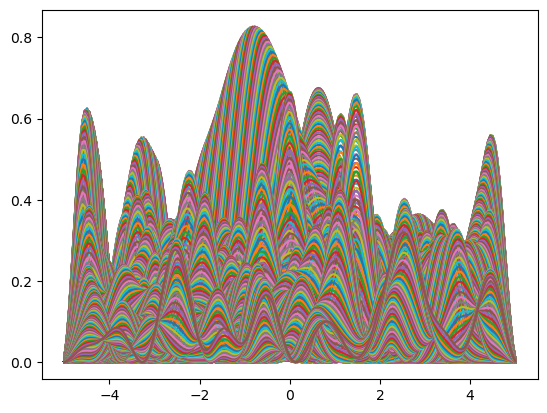

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,200)
minimo = np.zeros((1, 2000)).astype(complex)

while tempo < 1996:
    print(u1)
    psi_g[0:200, tempo] = psi[0:200, tempo]
    plt.plot(xs, np.absolute(psi[0:200, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi_g, psiExato), method='CG')
    print(f"Iteração: {tempo+1}")
    print(u2)
    print("---------------")
    minimo[0][tempo] = (u2.x[0])
    D = multMatrizes(M = 200, us = u2.x[0])
    psi[0:200, tempo+1] = np.matmul(D, psi[0:200, tempo])
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(random.uniform(-5, 5))
    u1.append(random.uniform(-5, 5))
    u1.append(random.uniform(-5, 5))

tempoFinal = time.time() - tempoInicial
print(tempoFinal)

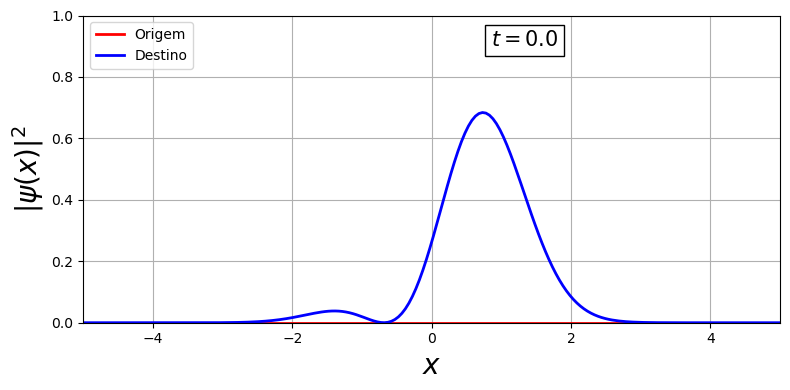

In [9]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,200)
    ln1.set_data(xs, np.absolute(psi_g[0:200,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:200,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Origem')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=2000, interval=2000)
ani.save('200x200.gif',writer='pillow',fps=20,dpi=100)